In [1]:
import pandas as pd
import json
import requests
from bs4 import BeautifulSoup
import csv
import regex as re
import unicodedata
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx 
from collections import Counter
import seaborn as sns
import numpy as np
import matplotlib.cm as cm
# from fa2 import ForceAtlas2
from Functions import DataCollection, DataCleaning, GetRatings, GetConnectedMoviesArtist, Plots
from imdb import IMDb
import powerlaw
import math

# Warning to ignore
import warnings
from matplotlib import MatplotlibDeprecationWarning
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=MatplotlibDeprecationWarning)

# **Data**
---

In [2]:
df_movies = pd.read_json('df_all.json', orient='table')
df_movies

,Title,Director,Cast,Country,Genre,Year,Hyperref,Decade,Rating,RatingLabel,DirectorIMDb,AirDate,Countries,BoxOffice
0,365 Days,barbara biaowas tomasz mandes,"anna-maria sieklucka,michele morrone, bronisaw...",europe,Thriller,2020,365_Days_(2020_film),20-29,3.3,Low,"[Barbara Bialowas, Tomasz Mandes]",07 Feb 2020,[Poland],9458590.0
1,7500,patrick vollrath,"joseph gordon-levitt,aylin tezel",mix,Action,2020,7500_(film),20-29,6.3,Moderate,[Patrick Vollrath],26 Dec 2019,"[Germany, Austria, United States, France]",NaN
2,Archenemy,adam egypt mortimer,"joe manganiello,skylan brooks, zolee griggs,pa...",mix,Action,2020,Archenemy_(film),20-29,5.0,Low,[Adam Egypt Mortimer],11 Dec 2020,[United States],NaN
3,Asuraguru,araajdheep,"vikram prabhu,mahima nambiar,subbaraju,yogi babu",india,Action,2020,Asuraguru,20-29,3.3,Low,[A. Rajdeep],11 Mar 2020,[India],NaN
4,Aswathama,ramana teja,"naga shourya,mehreen pirzada",india,Action,2020,Aswathama_(film),20-29,6.4,Moderate,[Ramana Teja],31 Jan 2020,[India],NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5242,The Promise,chen kaige,"hiroyuki sanada,jang dong-gun,cecilia cheung",china,Mix,2005,The_Promise_(2005_film),00-09,6.1,Moderate,[Terry George],21 Apr 2017,"[Spain, United States]",NaN
5243,Legend of the Guardians: The Owls of Ga'Hoole,zack snyder,"jim sturgess,joel edgerton,geoffrey rush,hugo ...",mix,Fantasy,2010,Legend_of_the_Guardians:_The_Owls_of_Ga%27Hoole,10-19,6.9,High,[Zack Snyder],04 Nov 2010,"[United States, Australia]",NaN
5244,Lethal,dustin rikert,"heather marie marsden,lorenzo lamas,frank zaga...",united states,Action,2004,Lethal_(film),00-09,7.8,High,NaN,NaN,[United States],NaN
5245,Piranha 3D,alexandre aja,"elisabeth shue,adam scott,jerry o'connell",united states,Mix,2010,Piranha_3-D,10-19,5.5,Moderate,[Alexandre Aja],07 Oct 2010,"[France, United States, Japan]",NaN


In [51]:
df_movies["Cast"][df_movies["Title"]=="Avengers: Endgame"].iloc[0]

'robert downey jr,chris evans,chris hemsworth,scarlett johansson,mark ruffalo,jeremy renner,brie larson,paul rudd,karen page,josh brolin'

In [3]:
color_palette_cividis = sns.color_palette("cividis", 40)
color_palette_plasma = sns.color_palette("plasma", 40)
color_palette_cividis_reversed = list(reversed(color_palette_cividis))
colorpalette = color_palette_plasma + color_palette_cividis_reversed
two_colors = colorpalette[::8][0:2]
three_ratings_colors = colorpalette[::17][0:3]
three_different_colors = colorpalette[::10][0:3]
genre_colors = colorpalette[::7][0:8]

hex_colors_genre = ['#1d068d', '#6700a7', '#a51f97', '#d3516f', '#f38649', '#fdc427', '#ecd54a', '#bcae6b']

# **Connected movies**
---

- Basic statistics
- Lav en indledende analyse af vores netværk. Hvilket type netvværk er vores netværk? scale free, random osv. 
- Lav en analyse af degrees. Degrees pr genre og pr rating.
- Hvem er top connected movies. Lav en analyse af dem, er det typiske skuespiller, director, genre, år? 
- Lav en analyse af top connected genre over tid. 
- Lav en analyse af top connected movies for hver genre.
- Centrality: either eigenvetor or betweeness centrality. uge 5. 


# **Basic Statistics**
---

In [4]:
def plot_bar(data_counts, column_string, cmap_string, title, x_data, y_data, x_label, y_label, ):
    # Colors
    num_unique = data_counts[column_string].nunique()
    cmap = cm.get_cmap(cmap_string)  # https://matplotlib.org/stable/users/explain/colors/colormaps.html
    colors = [cmap(i) for i in np.linspace(0, 1, num_unique)]
    
    # Bar plot
    sns.set(style="whitegrid") 
    plt.figure(figsize=(20, 7)) 
    barplot = sns.barplot(x=x_data, y=y_data, data=data_counts, palette=colors)
    plt.xticks(rotation=45, ha='right', fontsize=14)
    plt.title(title, fontsize=25, fontweight="bold")
    plt.xlabel(x_label, fontsize=16)
    plt.ylabel(y_label, fontsize=16)

    # Add count numbers on each bar
    for p in barplot.patches:
        barplot.annotate(format(p.get_height(), '.0f'), 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha = 'center', va = 'center', 
                        xytext = (0, 9), 
                        textcoords = 'offset points',
                        fontsize=14)
    plt.show()

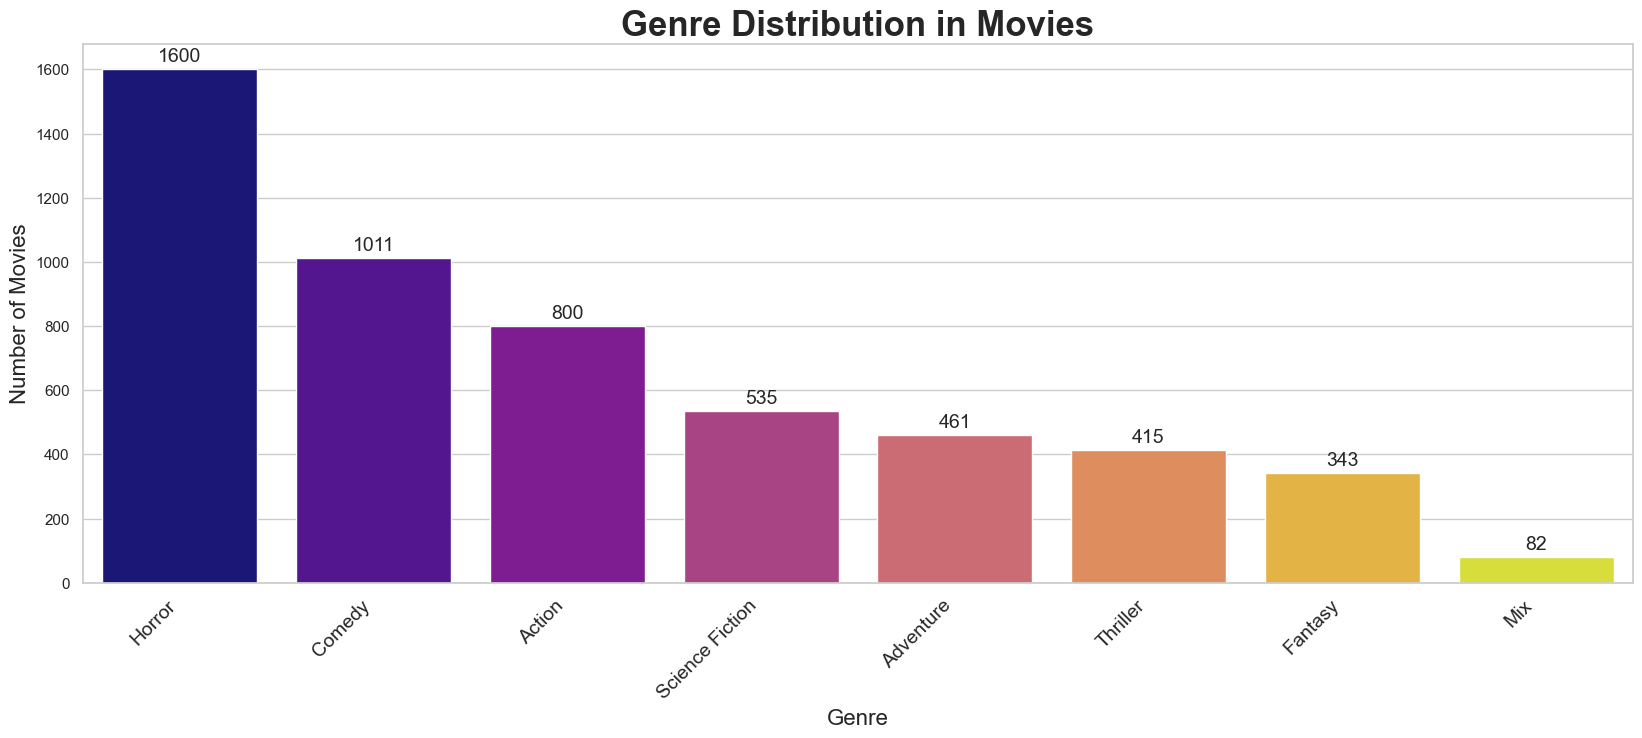

In [5]:
genre_counts = df_movies['Genre'].value_counts()
genre_counts = genre_counts.reset_index()
genre_counts.columns = ['Genre', 'Count']

plot_bar(data_counts = genre_counts,
         column_string = "Genre",
         cmap_string = "plasma",
         title = "Genre Distribution in Movies",
         x_data = "Genre",
         y_data = "Count",
         x_label = "Genre",
         y_label = "Number of Movies")

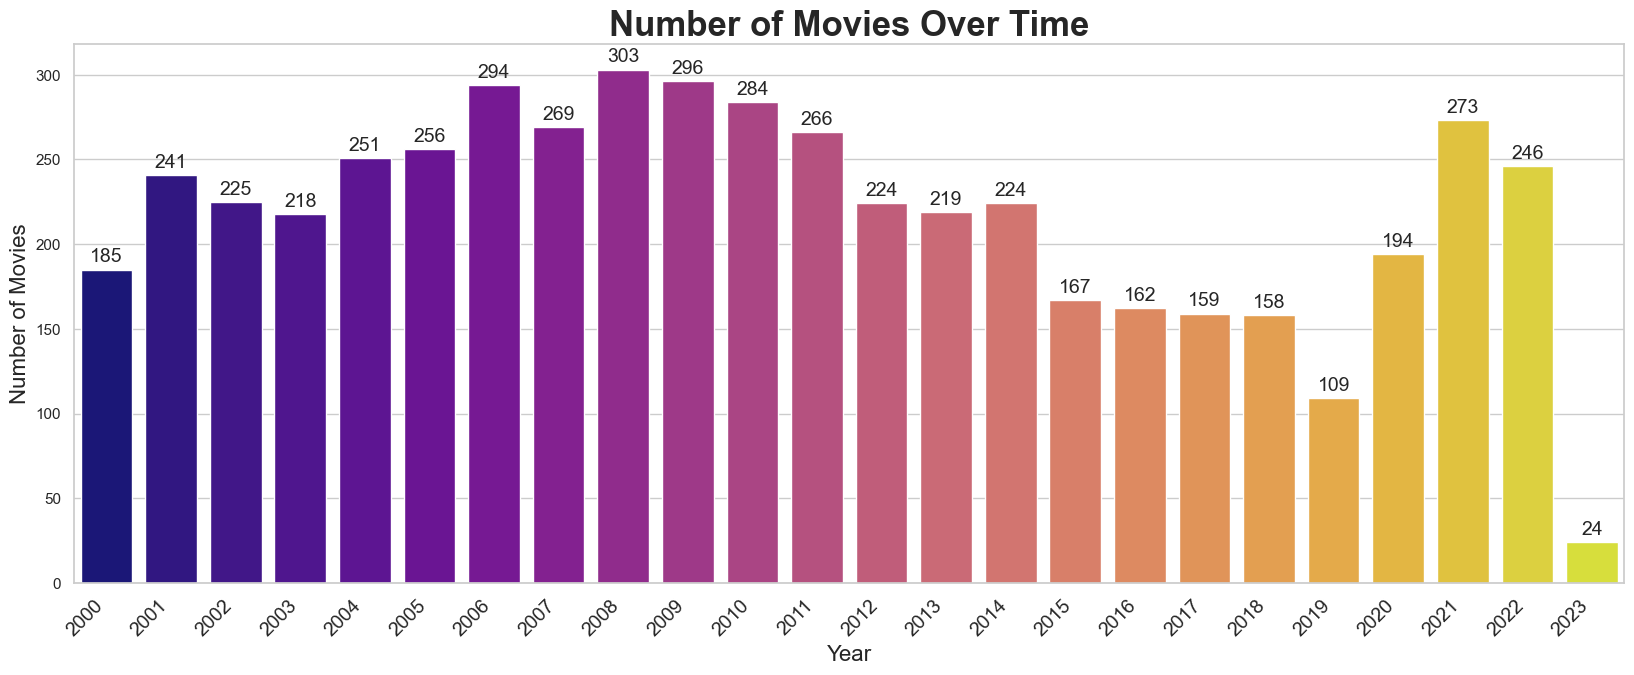

In [6]:
df_movies['Year'] = pd.to_numeric(df_movies['Year'], errors='coerce')
movies_per_year = df_movies.groupby('Year').size()
movies_per_year = movies_per_year.reset_index()
movies_per_year.columns = ['Year', 'Number of Movies']

plot_bar(data_counts = movies_per_year,
         column_string = "Year",
         cmap_string = "plasma",
         title = "Number of Movies Over Time",
         x_data = "Year",
         y_data = "Number of Movies",
         x_label = "Year",
         y_label = "Number of Movies")

## **Rating distribution**

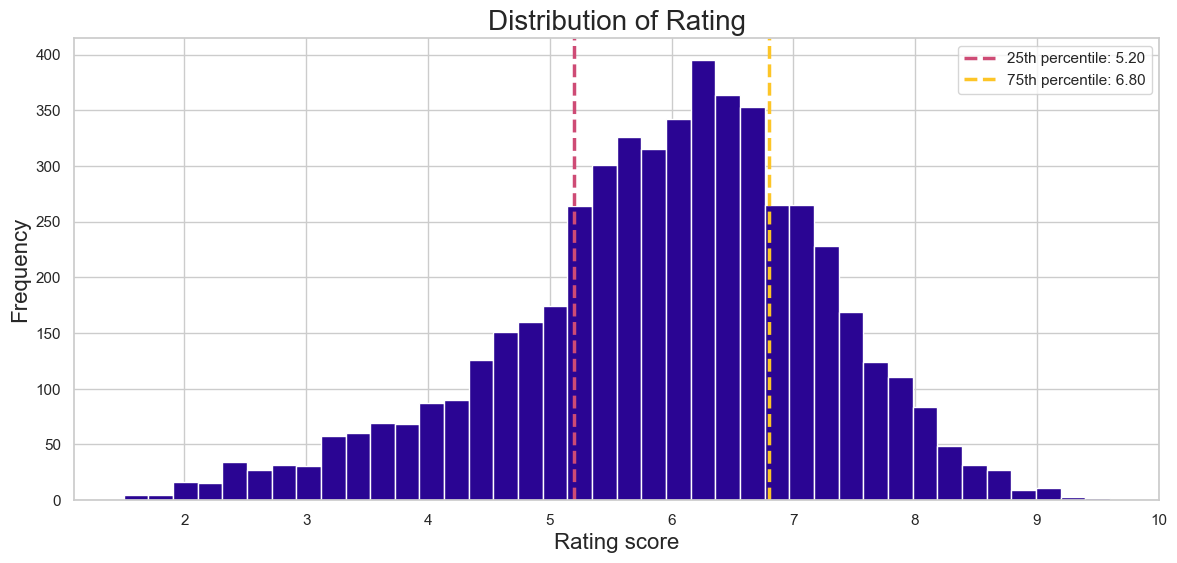

In [7]:
# Histogram
plt.figure(figsize=(14,6))
plt.hist(list(df_movies['Rating'].values), bins=40, edgecolor='white', color=colorpalette[1])
plt.xlabel('Rating score', fontsize=16)
plt.ylabel('Frequency',fontsize=16)
plt.title('Distribution of Rating', fontsize=20)

# Add vertical lines for mean and median
percentile_25 = np.percentile(list(df_movies['Rating'].values), 25)
percentile_75 = np.percentile(list(df_movies['Rating'].values), 75)
plt.axvline(percentile_25, color=colorpalette[20], linestyle="dashed", linewidth=2.5, label=f"25th percentile: {percentile_25:.2f}")
plt.axvline(percentile_75, color=colorpalette[35], linestyle="dashed", linewidth=2.5, label=f"75th percentile: {percentile_75:.2f}")
plt.legend()
plt.show()

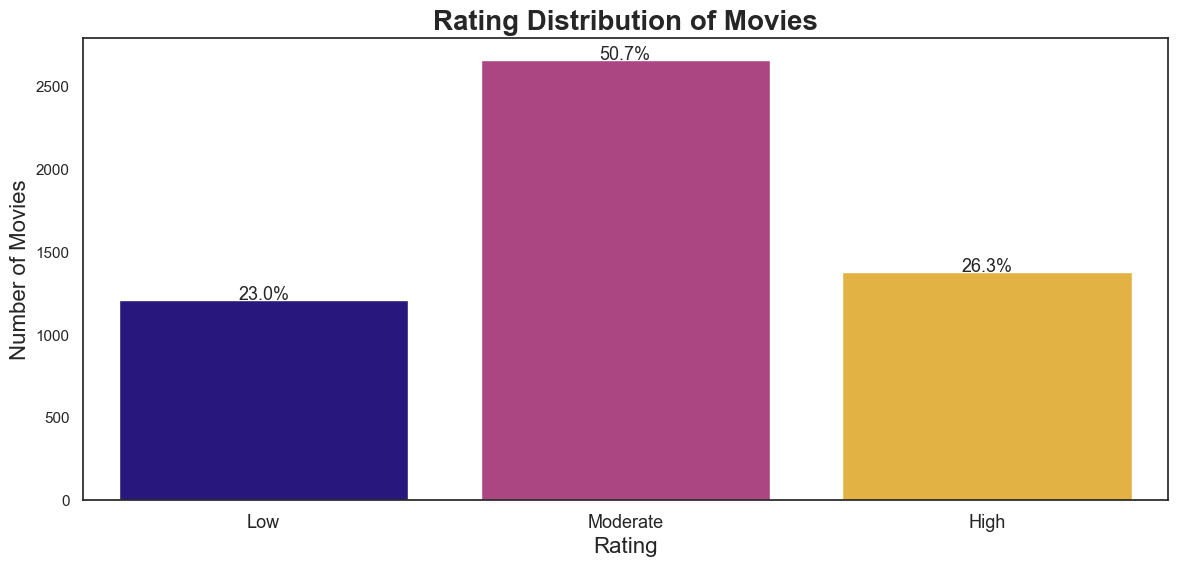

In [8]:
rating_counts = df_movies['RatingLabel'].value_counts()
rating_counts = rating_counts.reset_index()
rating_counts.columns = ['RatingLabel', 'Count']
ordered_labels = ['Low', 'Moderate', 'High']
rating_counts['RatingLabel'] = pd.Categorical(rating_counts['RatingLabel'], categories=ordered_labels, ordered=True)
rating_counts = rating_counts.sort_values('RatingLabel')

plots = Plots()
plots.plot_bar(x = 'RatingLabel', y = 'Count', data = rating_counts, title = 'Rating Distribution of Movies', 
         xlabel= 'Rating', ylabel= 'Number of Movies', figsize=(14,6), 
         color_palette=three_ratings_colors, order=None)

# **Network**
---

In [9]:
with open('connected_movies_and_artists.json', 'r') as file:
    connected_movies = json.load(file)

# connected_movies

## **Creating the network**

In [10]:
G_movies = nx.Graph()

# Add nodes
movies_nodes = list(connected_movies.keys())
G_movies.add_nodes_from(movies_nodes)

node_attr = df_movies[['Title','Director','Cast','Country','Genre', 'RatingLabel',
                'Year', 'Decade']].set_index('Title').to_dict('index') # Creating a dictionary with the characters and their attributes

nx.set_node_attributes(G_movies, node_attr) #Adding attributes to the graph

for movie in connected_movies.keys():
    for connected_movie in connected_movies[movie]: 
        weight = len(connected_movies[movie][connected_movie])
        attribute_value = connected_movies[movie][connected_movie]
        G_movies.add_edges_from([(movie, connected_movie)], weight=weight, attribute_name=attribute_value)

In [11]:
print("The network consist of: ", G_movies.number_of_nodes(), " nodes")
print("The network consist of: ", G_movies.number_of_edges(), " edges")

The network consist of:  5247  nodes
The network consist of:  32502  edges


## **Largest Connected Component**

In [12]:
connected_components = nx.connected_components(G_movies)
largest_cc = max(connected_components, key=len)
G_largest_cc = G_movies.subgraph(largest_cc).copy()

In [13]:
print("The largest connected component network consist of: ", G_largest_cc.number_of_nodes(), " nodes")
print("The largest connected component network consist of: ", G_largest_cc.number_of_edges(), " edges")

The largest connected component network consist of:  3935  nodes
The largest connected component network consist of:  32122  edges


In [14]:
# Dataframe with only the movies in the largest connected component
movies_largest_cc = list(G_largest_cc.nodes())
df_movies_largest_cc = df_movies[df_movies['Title'].isin(movies_largest_cc)]

## **Type of network**

In [15]:
degree_sequence = [d for _, d in G_largest_cc.degree()]
fit = powerlaw.Fit(degree_sequence)
exponent = fit.power_law.alpha
print("Exponent of the degree distribution:", exponent)

Calculating best minimal value for power law fit
Exponent of the degree distribution: 6.315537298451607


$\gamma>3$ indicates that this falls into the *random network regime*. This makes the network hard to distinguish from a random network.

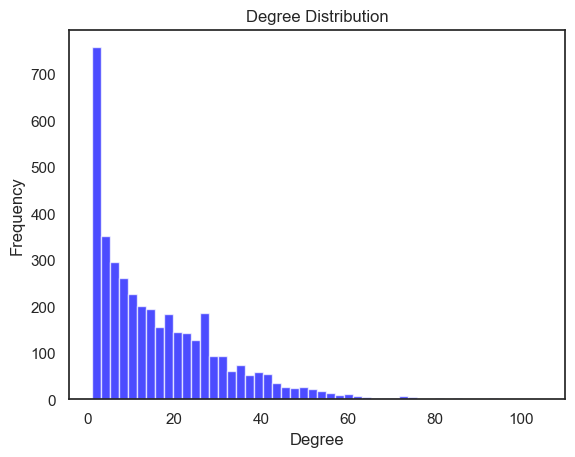

In [54]:
plt.hist(degree_sequence, bins=50, color="blue", alpha=0.7)
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()

## **Degrees analysis**

In [16]:
# df_largest_cc = df_largest_cc.drop(columns='Degree')
df_degree_sequence = pd.DataFrame(list(G_largest_cc.degree()), columns=['Title', 'Degree'])
df_largest_cc_with_degrees = df_movies_largest_cc.merge(df_degree_sequence, on='Title')

# For genre
average_degree_by_genre = df_largest_cc_with_degrees.groupby('Genre')['Degree'].mean()
sorted_average_degree_by_genre = average_degree_by_genre.sort_values(ascending=False)

# For rating
average_degree_by_rating = df_largest_cc_with_degrees.groupby('RatingLabel')['Degree'].mean()
sorted_average_degree_by_rating = average_degree_by_rating.sort_values(ascending=False)

# Print
print(f'Sorted average degree by genre:\n{sorted_average_degree_by_genre}\n')
print(f'Sorted average degree by rating:\n{sorted_average_degree_by_rating}')

Sorted average degree by genre:
Genre
Fantasy            22.430108
Action             21.774627
Adventure          19.460490
Thriller           17.844875
Comedy             16.950588
Science Fiction    16.566986
Mix                16.029851
Horror              8.023835
Name: Degree, dtype: float64

Sorted average degree by rating:
RatingLabel
High        19.560112
Moderate    17.167137
Low          9.204607
Name: Degree, dtype: float64


From the print above, "Fantasy" movies tend to share actors with more other movies on average. This suggests that the genre tend to have larger casts or that actors in these genres tend to work in more movies within the same genre.

Similarly, the sorted average degree by rating shows that movies with a ‘High’ rating tend to share actors with more other movies on average. This could suggest that highly rated movies tend to have actors who work in more movies, or that actors who work in highly rated movies tend to also work in other highly rated movies.

### **Top connected movies**

In [17]:
top_connected_movies = df_degree_sequence.sort_values('Degree', ascending=False)
degree_of_top_10th_connected_movies = top_connected_movies['Degree'].iloc[9]  # Get the degree of the 10th movie
top_10_connected_movies = top_connected_movies[top_connected_movies['Degree'] >= degree_of_top_10th_connected_movies]
top_10_connected_movies

,Title,Degree
985,Amsterdam,105
3864,Thor: Love and Thunder,100
3487,Don't Look Up,97
3412,Avengers: Endgame,93
3486,Dolittle,93
3508,F9,85
3909,Zack Snyder's Justice League,85
3764,The Avengers,81
3865,Thor: Ragnarok,81
3014,Night at the Museum: Secret of the Tomb,78


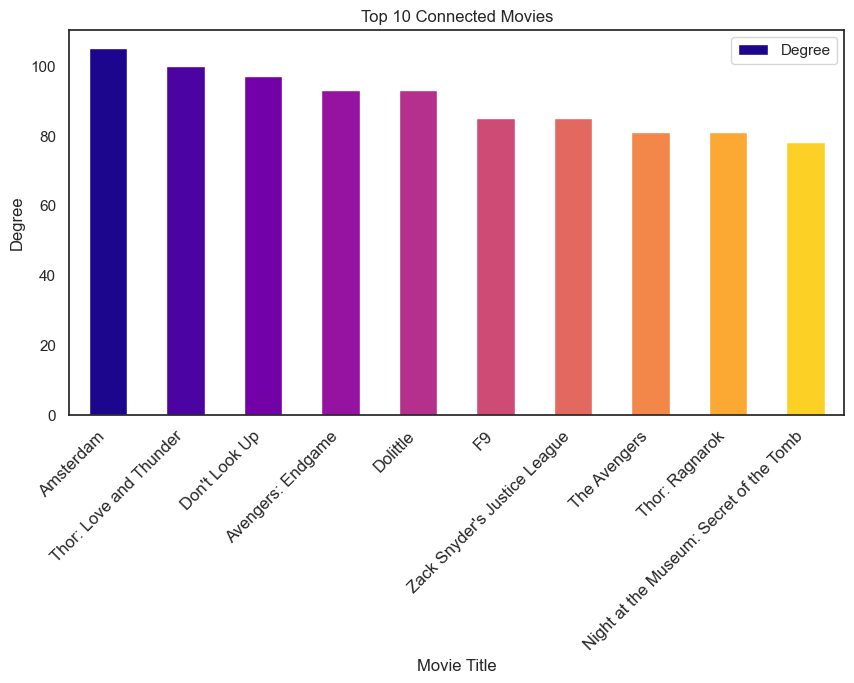

In [18]:
top_10_connected_movies.plot.bar(x="Title", y="Degree", color = colorpalette[::4], figsize=(10, 5))
plt.title("Top 10 Connected Movies")
plt.xlabel("Movie Title")
plt.ylabel("Degree")
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.show()

In [19]:
top_10_movies_details = pd.merge(top_10_connected_movies, df_movies, on='Title', how='left')
top_10_movies_details

,Title,Degree,Director,Cast,Country,Genre,Year,Hyperref,Decade,Rating,RatingLabel,DirectorIMDb,AirDate,Countries,BoxOffice
0,Amsterdam,105,david o russell,"christian bale,margot robbie,john david washin...",united states,Comedy,2022,Amsterdam_(2022_film),20-29,6.1,Moderate,[David O. Russell],06 Oct 2022,"[United States, Japan]",NaN
1,Thor: Love and Thunder,100,taika waititi,"chris hemsworth,tessa thompson,natalie portman...",united states,Action,2022,Thor:_Love_and_Thunder,20-29,6.2,Moderate,[Taika Waititi],06 Jul 2022,"[Australia, United States]",NaN
2,Don't Look Up,97,adam mc kay,"jennifer lawrence,leonardo di caprio,cate blan...",united states,Comedy,2021,Don%27t_Look_Up_(2021_film),20-29,7.2,High,[Adam McKay],08 Dec 2021,[United States],NaN
3,Avengers: Endgame,93,anthony and joseph russo,"robert downey jr,chris evans,chris hemsworth,s...",united states,Action,2019,Avengers:_Endgame,10-19,8.4,High,"[Anthony Russo, Joe Russo]",24 Apr 2019,[United States],NaN
4,Dolittle,93,stephen gaghan,"robert downey jr,antonio banderas,michael shee...",united states,Fantasy,2020,Dolittle_(film),20-29,5.6,Moderate,[Stephen Gaghan],23 Jan 2020,"[United States, China, United Kingdom, Japan]",251402490.0
5,F9,85,justin lin,"vin diesel,michelle rodriguez,tyrese gibson,ch...",united states,Action,2021,F9_(film),20-29,5.2,Moderate,[Justin Lin],24 Jun 2021,[United States],NaN
6,Zack Snyder's Justice League,85,zack snyder,"ben affleck,henry cavill,amy adams,gal gadot,r...",united states,Science Fiction,2021,Zack_Snyder%27s_Justice_League,20-29,7.9,High,[Zack Snyder],18 Mar 2021,[United States],NaN
7,The Avengers,81,joss whedon,"robert downey jr,chris evans,scarlett johansso...",united states,Adventure,2012,The_Avengers_(2012_film),10-19,8.0,High,[Joss Whedon],26 Apr 2012,[United States],NaN
8,Thor: Ragnarok,81,taika waititi,"chris hemsworth,tom hiddleston,cate blanchett,...",united states,Fantasy,2017,Thor:_Ragnarok,10-19,7.9,High,[Taika Waititi],26 Oct 2017,[United States],NaN
9,Night at the Museum: Secret of the Tomb,78,shawn levy,"ben stiller,robin williams,owen wilson,rebel w...",united states,Fantasy,2014,Night_at_the_Museum:_Secret_of_the_Tomb,10-19,6.2,Moderate,[Shawn Levy],05 Feb 2015,"[United Kingdom, United States]",NaN


In [20]:
# top_10_movies_details.describe()

In [21]:
print(top_10_movies_details['Genre'].value_counts())

Genre
Action             3
Fantasy            3
Comedy             2
Science Fiction    1
Adventure          1
Name: count, dtype: int64


In [22]:
print(top_10_movies_details['Decade'].value_counts())
# Newer movies are more connected

Decade
20-29    6
10-19    4
Name: count, dtype: int64


In [23]:
print(top_10_movies_details['RatingLabel'].value_counts())

RatingLabel
Moderate    5
High        5
Name: count, dtype: int64


In [24]:
print(top_10_movies_details['Director'].unique())

['david o russell' 'taika waititi' 'adam mc kay'
 'anthony and joseph russo' 'stephen gaghan' 'justin lin' 'zack snyder'
 'joss whedon' 'shawn levy']


In [25]:
# top_10_movies_details_print = top_10_movies_details.sort_values(by='Rating', ascending=False)
# print(top_10_movies_details_print)

In [26]:
# test = df_movies.sort_values(by='Rating', ascending=False)
# print(test)

## **Top connected movies in each genre**

C:\Users\mydun\AppData\Local\Temp\ipykernel_32464\534584404.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i//3, i%3].set_xticklabels(axs[i//3, i%3].get_xticklabels(), rotation=45, ha='right', fontsize=12)
C:\Users\mydun\AppData\Local\Temp\ipykernel_32464\534584404.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i//3, i%3].set_xticklabels(axs[i//3, i%3].get_xticklabels(), rotation=45, ha='right', fontsize=12)
C:\Users\mydun\AppData\Local\Temp\ipykernel_32464\534584404.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i//3, i%3].set_xticklabels(axs[i//3, i%3].get_xticklabels(), rotation=45, ha='right', fontsize=12)
C:\Users\mydun\AppData\Local\Temp\ipykernel_32464\534584404.py:17: UserWarning: set_ticklabels() sho

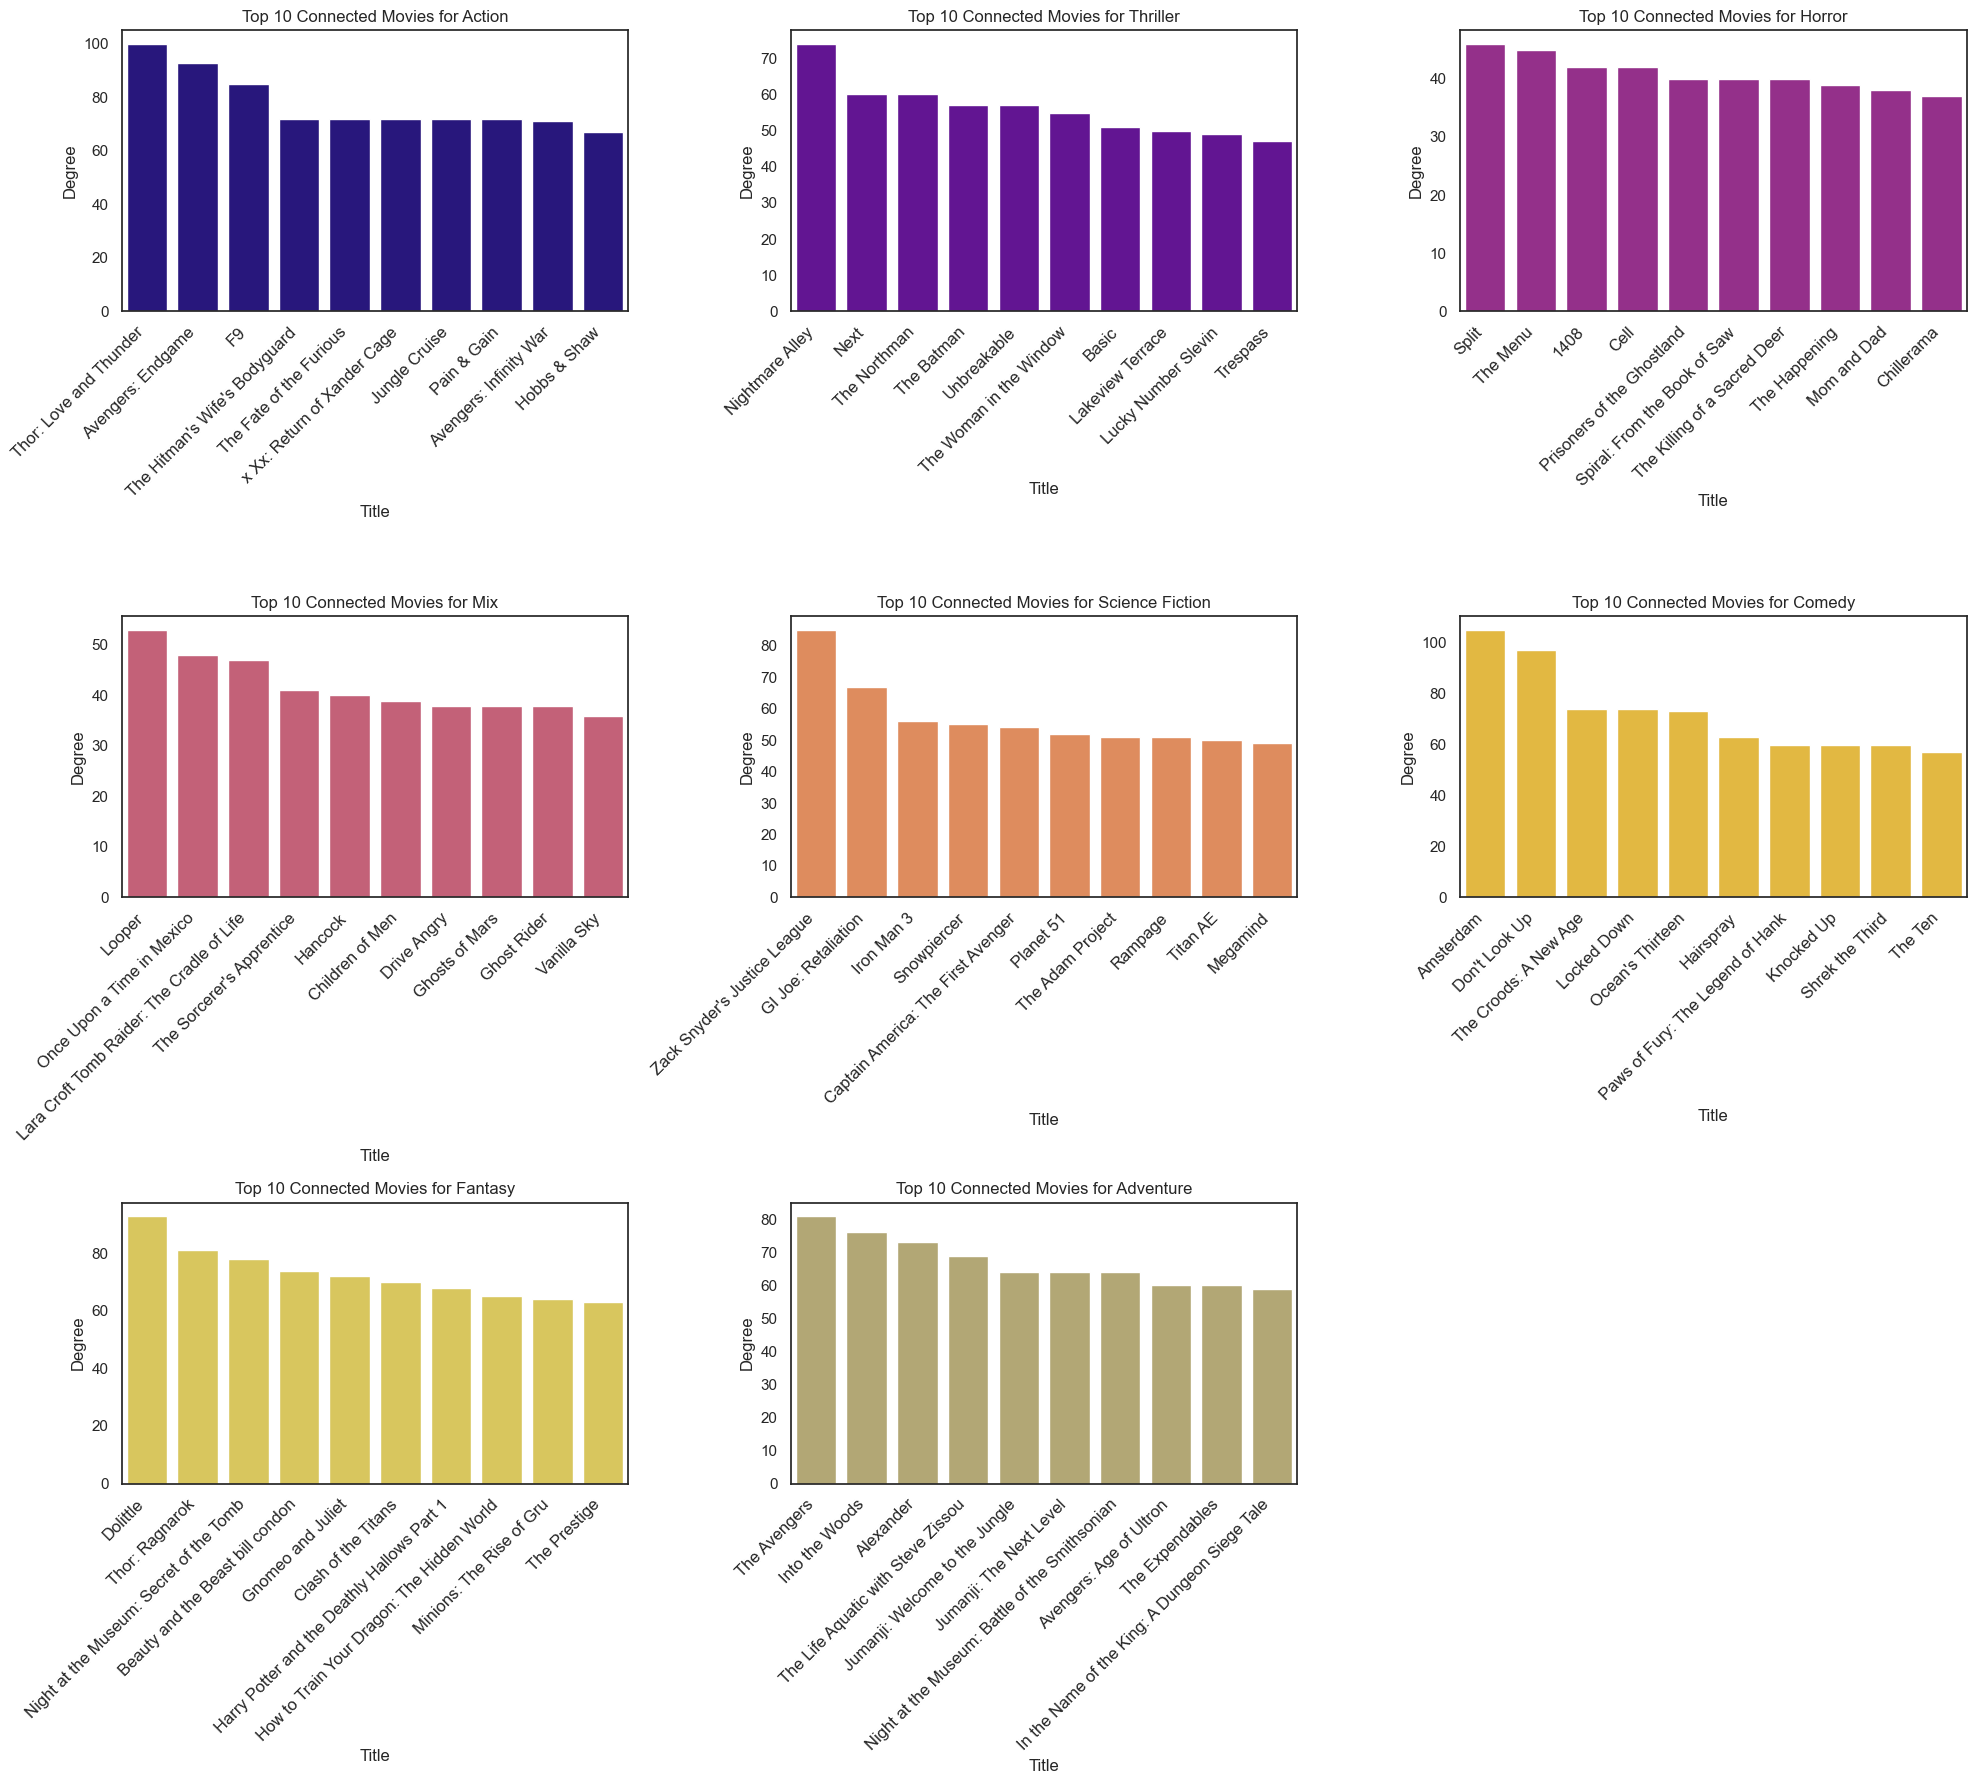

In [27]:
# Make plot for each genre
genres = df_largest_cc_with_degrees['Genre'].unique()
genre_color_dict = dict(zip(genres, hex_colors_genre))


# Figure properties
nrows = math.ceil(len(genres) / 3)
fig, axs = plt.subplots(nrows, 3, figsize=(20, 6*nrows))

for i, genre in enumerate(genres):
    # Top 10 movies of the genre
    top_movies = df_largest_cc_with_degrees[df_largest_cc_with_degrees['Genre'] == genre].nlargest(10, 'Degree')
    
    # Bar plot
    sns.barplot(x='Title', y='Degree', data=top_movies, ax=axs[i//3, i%3], color=genre_color_dict[genre])
    axs[i//3, i%3].set_title(f'Top 10 Connected Movies for {genre}')
    axs[i//3, i%3].set_xticklabels(axs[i//3, i%3].get_xticklabels(), rotation=45, ha='right', fontsize=12)

# Remove empty subplots
if len(genres) % 3 != 0:
    for j in range(len(genres) % 3, 3):
        fig.delaxes(axs[nrows-1, j])

plt.tight_layout()
plt.show()


### **Degree centrality**

In [28]:
# Degree centrality
degree_centrality = nx.degree_centrality(G_largest_cc)
df_degree_centrality = pd.DataFrame.from_dict(degree_centrality, orient='index', columns=['Degree Centrality'])
top_10_movies_degree_centrality = df_degree_centrality.sort_values('Degree Centrality', ascending=False).head(10)
print(top_10_movies_degree_centrality)


                                         Degree Centrality
Amsterdam                                         0.026690
Thor: Love and Thunder                            0.025419
Don't Look Up                                     0.024657
Avengers: Endgame                                 0.023640
Dolittle                                          0.023640
F9                                                0.021607
Zack Snyder's Justice League                      0.021607
The Avengers                                      0.020590
Thor: Ragnarok                                    0.020590
Night at the Museum: Secret of the Tomb           0.019827


Degree centrality = Number of direct connections a node has in the network.
- High degree centrality = many connections to other movies. -> The cast is widely represented across the network.

### **Betweenness centrality**

In [29]:
# Betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G_largest_cc)
df_betweenness_centrality = pd.DataFrame.from_dict(betweenness_centrality, orient='index', columns=['Betweenness Centrality'])
top_10_movies_betweenness_centrality = df_betweenness_centrality.sort_values('Betweenness Centrality', ascending=False).head(10)
print(top_10_movies_betweenness_centrality)
# Approx 1.10 min

                                    Betweenness Centrality
x Xx: Return of Xander Cage                       0.020512
Baywatch                                          0.020063
Dolittle                                          0.018335
Don't Look Up                                     0.015928
Snowpiercer                                       0.015479
Grasshopper                                       0.015402
Justice League Dark: Apokolips War                0.013833
Man of Tai Chi                                    0.013306
The Seaside Motel                                 0.013155
Krrish                                            0.012942


Betweenness centrality = Measure of a node's centrality in the network, based on the number of shortest paths that pass through the node.
- High betweenness centrality = A movie that connects many pairs of movies -> These movies might not have the largest casts, but they have key actors who link together otherwise disconnected groups of movies.

### **Eigenvector centrality**

In [30]:
# Eigenvector centrality
eigenvector_centrality = nx.eigenvector_centrality(G_largest_cc)
df_eigenvector_centrality = pd.DataFrame.from_dict(eigenvector_centrality, orient='index', columns=['Eigenvector Centrality'])
top_10_movies_eigenvector_centrality = df_eigenvector_centrality.sort_values('Eigenvector Centrality', ascending=False).head(10)
print(top_10_movies_eigenvector_centrality)


                               Eigenvector Centrality
The Avengers                                 0.120591
The Fate of the Furious                      0.113446
x Xx: Return of Xander Cage                  0.104644
Hobbs & Shaw                                 0.098976
Thor: Love and Thunder                       0.094516
The Hitman's Wife's Bodyguard                0.094312
GI Joe: Retaliation                          0.093741
Unbreakable                                  0.092996
Fast & Furious 6                             0.091955
Furious 7                                    0.091955


Eigenvector centrality = Measure of influence of a node in a network.
- High eigenvector centrality = A movie that is connected to other highly connected movies. -> A movie with high eigenvector centrality may not have the most number of common actors, but it is connected to other movies that do. This could suggest that the movie shares actors with a number of influential or popular movies.

# **Directors**
---

In [31]:
df_movies_exploded = df_movies.explode('DirectorIMDb')
num_unique_directors = df_movies_exploded['DirectorIMDb'].nunique()
print("Number of unique directors:", num_unique_directors)

Number of unique directors: 3422


In [32]:
# Frequency of each director
# director_counts = df_movies['Director'].value_counts()
# director_counts
director_frequency = df_movies_exploded['DirectorIMDb'].value_counts()
# director_frequency

In [33]:
# Get all directors with frequency greater than or equal to the 10th director's frequency
tenth_director_frequency = director_frequency.nlargest(10).iloc[-1]
top_directors = director_frequency[director_frequency >= tenth_director_frequency]
top_directors

DirectorIMDb
Robert Rodriguez      14
Shawn Levy            13
Tim Burton            12
Ridley Scott          12
Takashi Miike         11
Doug Liman            10
Guillermo del Toro    10
Peter Jackson         10
Johannes Roberts      10
David DeCoteau        10
Zack Snyder           10
Steven Soderbergh     10
Name: count, dtype: int64

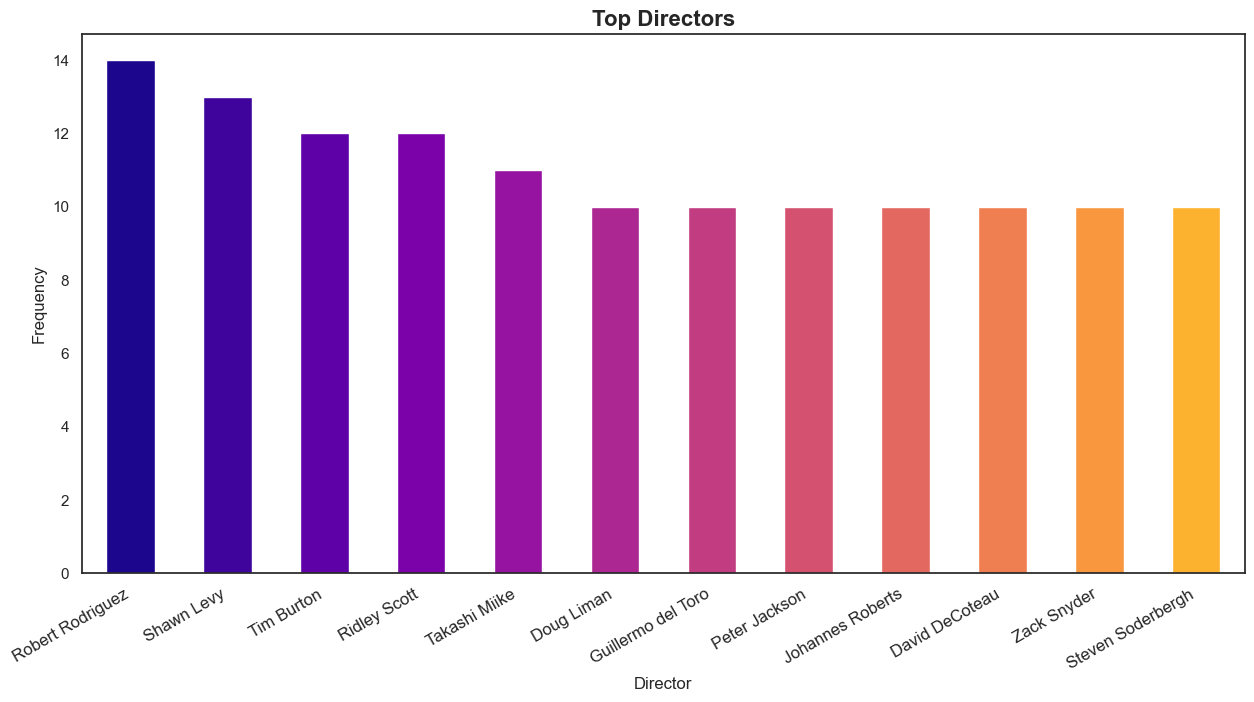

In [34]:
plt.figure(figsize=(15, 7))
top_directors.plot.bar(color = colorpalette[::3], linewidth=1)
plt.title("Top Directors", fontweight="bold", fontsize=16)
plt.xlabel("Director")
plt.ylabel("Frequency")
plt.xticks(rotation=30, ha='right', fontsize=12)
plt.show()